***EXCERCISE - 1***

In [51]:
from bs4 import BeautifulSoup
import time
from selenium import webdriver
import pandas as pd

def create_attributes(data_stats, special_extractors=None):
    special_extractors = special_extractors or {}
    return [(stat, special_extractors.get(stat, lambda td: td.get_text(strip=True))) for stat in data_stats]

def extract_data(tr, attributes):
    row_data = {}
    for data_stat, extractor in attributes:
        td = tr.find('td', {'data-stat': data_stat})
        row_data[data_stat] = extractor(td) if td else None
    return row_data

def scrape_table(driver, url, attributes, is_goalkeeper=False):
    driver.get(url)
    time.sleep(0.5)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table', {'class': 'min_width sortable stats_table shade_zero now_sortable sticky_table eq2 re2 le2'})
    if not table:
        return pd.DataFrame()
    
    tbody = table.find('tbody')
    data = []
    for tr in tbody.find_all('tr'):
        if 'thead' in tr.get('class', []):
            continue
        minutes_90s = tr.find('td', {'data-stat': 'minutes_90s'}).get_text(strip=True)
        if float(minutes_90s) < 1.0:
            continue
        if is_goalkeeper and 'GK' not in tr.find('td', {'data-stat': 'position'}).get_text(strip=True):
            continue
        row_data = extract_data(tr, attributes)
        data.append(row_data)
    
    return pd.DataFrame(data)

driver = webdriver.Chrome()

standard_stats = [
    'player', 'nationality', 'team', 'position', 'birth_year', 'games', 'games_starts', 'minutes',
    'goals', 'assists', 'cards_yellow', 'cards_red', 'xg', 'xg_assist', 'progressive_carries',
    'progressive_passes', 'progressive_passes_received', 'goals_per90', 'assists_per90',
    'xg_per90', 'xg_assist_per90'
]
standard_attributes = create_attributes(standard_stats, {
    'nationality': lambda td: td.find('a').find('span').contents[-1].strip(),
    'birth_year': lambda td: str(2025 - int(td.get_text(strip=True)))
})

goalkeeping_attributes = create_attributes([
    'player', 'team', 'position', 'gk_goals_against_per90', 'gk_save_pct', 'gk_clean_sheets_pct', 'gk_pens_save_pct'
])

shooting_attributes = create_attributes([
    'player', 'team', 'position', 'shots_on_target_pct', 'shots_on_target_per90', 'goals_per_shot', 'average_shot_distance'
])

passing_attributes = create_attributes([
    'player', 'team', 'position', 'passes_completed', 'passes_pct', 'passes_total_distance', 'passes_pct_short',
    'passes_pct_medium', 'passes_pct_long', 'assisted_shots', 'passes_into_final_third',
    'passes_into_penalty_area', 'crosses_into_penalty_area', 'progressive_passes'
])

gca_attributes = create_attributes(['player', 'team', 'position', 'sca', 'sca_per90', 'gca', 'gca_per90'])

defense_attributes = create_attributes([
    'player', 'team', 'position', 'tackles', 'tackles_won', 'challenges', 'challenges_lost', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions'
])

possession_attributes = create_attributes([
    'player', 'team', 'position', 'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
    'touches_att_pen_area', 'take_ons', 'take_ons_won', 'take_ons_tackled', 'carries',
    'carries_progressive_distance', 'progressive_carries', 'carries_into_final_third',
    'carries_into_penalty_area', 'miscontrols', 'dispossessed', 'passes_received',
    'progressive_passes_received'
])

misc_attributes = create_attributes([
    'player', 'team', 'position', 'fouls', 'fouled', 'offsides', 'crosses', 'ball_recoveries', 'aerials_won',
    'aerials_lost', 'aerials_won_pct'
])

df_standard = scrape_table(driver, 'https://fbref.com/en/comps/9/stats/Premier-League-Stats', standard_attributes)
df_goalkeeping = scrape_table(driver, 'https://fbref.com/en/comps/9/keepers/Premier-League-Stats', goalkeeping_attributes, is_goalkeeper=True)
df_shooting = scrape_table(driver, 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats', shooting_attributes)
df_passing = scrape_table(driver, 'https://fbref.com/en/comps/9/passing/Premier-League-Stats', passing_attributes)
df_gca = scrape_table(driver, 'https://fbref.com/en/comps/9/gca/Premier-League-Stats', gca_attributes)
df_defense = scrape_table(driver, 'https://fbref.com/en/comps/9/defense/Premier-League-Stats', defense_attributes)
df_possession = scrape_table(driver, 'https://fbref.com/en/comps/9/possession/Premier-League-Stats', possession_attributes)
df_misc = scrape_table(driver, 'https://fbref.com/en/comps/9/misc/Premier-League-Stats', misc_attributes)

df = df_standard
for df_temp in [df_goalkeeping, df_shooting, df_passing, df_gca, df_defense, df_possession, df_misc]:
    df = df.merge(df_temp, on=['player', 'team', 'position'], how='left')

df = df.sort_values(by='player')

# Thêm cột No. và giữ cột player
df.insert(0, 'No.', range(len(df)))

# Tạo bản sao và xử lý giá trị NaN
tmp = df.copy()
pd.set_option('future.no_silent_downcasting', True)
tmp = tmp.fillna('N/A')
tmp = tmp.astype(str)
tmp = tmp.replace(['nan', 'NaN', '', None], 'N/A')

# Định nghĩa MultiIndex cho cột, thêm cột Player sau No.
columns = [('', '', 'No.'), ('', '', 'Player')] + [
    ('', 'Nation', 'nationality'), ('', 'Team', 'team'), ('', 'Position', 'position'), 
    ('', 'Age', 'birth_year'), ('', 'Playing Time', 'games'), ('', '', 'games_starts'), ('', '', 'minutes'),
    ('', 'Performance', 'goals'), ('', '', 'assists'), ('', '', 'cards_yellow'), ('', '', 'cards_red'), 
    ('', 'Expected', 'xg'), ('', '', 'xg_assist'), ('', 'Progression', 'progressive_carries'), 
    ('', '', 'progressive_passes'), ('', '', 'progressive_passes_received'), ('', 'Per 90 minutes', 'goals_per90'), 
    ('', '', 'assists_per90'), ('', '', 'xg_per90'), ('', '', 'xg_assist_per90'), 
    ('Goalkeeping', 'Performance', 'gk_goals_against_per90'), ('', '', 'gk_save_pct'), ('', '', 'gk_clean_sheets_pct'), 
    ('', 'Penalty Kicks', 'gk_pens_save_pct'), ('Shooting', 'Standard', 'shots_on_target_pct'),
    ('', '', 'shots_on_target_per90'), ('', '', 'goals_per_shot'), ('', '', 'average_shot_distance'), 
    ('Passing', 'Total', 'passes_completed'), ('', '', 'passes_pct'), ('', '', 'passes_total_distance'),
    ('', 'Short', 'passes_pct_short'), ('', 'Medium', 'passes_pct_medium'), ('', 'Long', 'passes_pct_long'), 
    ('', 'Expected', 'assisted_shots'), ('', '', 'passes_into_final_third'), ('', '', 'passes_into_penalty_area'),
    ('', '', 'crosses_into_penalty_area'), ('', '', 'progressive_passes'), ('Goal and Shot Creation', 'SCA', 'sca'),
    ('', '', 'sca_per90'), ('', 'GCA', 'gca'), ('', '', 'gca_per90'), ('Defensive Actions', 'Tackles', 'tackles'), 
    ('', '', 'tackles_won'), ('', 'Challenges', 'challenges'), ('', '', 'challenges_lost'), 
    ('', 'Blocks', 'blocks'), ('', '', 'blocked_shots'), ('', '', 'blocked_passes'), ('', '', 'interceptions'),
    ('Possession', 'Touches', 'touches'), ('', '', 'touches_def_pen_area'), ('', '', 'touches_def_3rd'), 
    ('', '', 'touches_mid_3rd'), ('', '', 'touches_att_3rd'), ('', '', 'touches_att_pen_area'), 
    ('', 'Take-Ons', 'take_ons'), ('', '', 'take_ons_won'), ('', '', 'take_ons_tackled'), 
    ('', 'Carries', 'carries'), ('', '', 'carries_progressive_distance'), ('', '', 'progressive_carries'), 
    ('', '', 'carries_into_final_third'), ('', '', 'carries_into_penalty_area'), ('', '', 'miscontrols'), 
    ('', '', 'dispossessed'), ('', 'Receiving', 'passes_received'), ('', '', 'progressive_passes_received'),
    ('Miscellaneous Stats', 'Performance', 'fouls'), ('', '', 'fouled'), ('', '', 'offsides'), ('', '', 'crosses'), 
    ('', '', 'ball_recoveries'), ('', 'Aerial Duels', 'aerials_won'), ('', '', 'aerials_lost'), 
    ('', '', 'aerials_won_pct')
]

multi_cols = pd.MultiIndex.from_tuples(columns)
tmp.columns = multi_cols

# Lưu vào file CSV
tmp.to_csv('results.csv', index=False)

driver.quit()

***EXCERCISE - 2:***

**Identify the top 3 players with the highest and lowest scores for each statistic. Save result 
to a file name ‘top_3.txt'**

In [2]:
from bs4 import BeautifulSoup
import time
from selenium import webdriver
import pandas as pd
import uuid

def create_attributes(data_stats, special_extractors=None):
    special_extractors = special_extractors or {}
    return [(stat, special_extractors.get(stat, lambda td: td.get_text(strip=True))) for stat in data_stats]

def extract_data(tr, attributes):
    row_data = {}
    for data_stat, extractor in attributes:
        td = tr.find('td', {'data-stat': data_stat})
        row_data[data_stat] = extractor(td) if td else None
    return row_data

def scrape_table(driver, url, attributes, is_goalkeeper=False):
    driver.get(url)
    time.sleep(0.5)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table', {'class': 'min_width sortable stats_table shade_zero now_sortable sticky_table eq2 re2 le2'})
    if not table:
        return pd.DataFrame()
    
    tbody = table.find('tbody')
    data = []
    for tr in tbody.find_all('tr'):
        if 'thead' in tr.get('class', []):
            continue
        minutes_90s = tr.find('td', {'data-stat': 'minutes_90s'}).get_text(strip=True)
        if float(minutes_90s) < 1.0:
            continue
        if is_goalkeeper and 'GK' not in tr.find('td', {'data-stat': 'position'}).get_text(strip=True):
            continue
        row_data = extract_data(tr, attributes)
        data.append(row_data)
    
    return pd.DataFrame(data)

driver = webdriver.Chrome()

standard_stats = [
    'player', 'nationality', 'team', 'position', 'birth_year', 'games', 'games_starts', 'minutes',
    'goals', 'assists', 'cards_yellow', 'cards_red', 'xg', 'xg_assist', 'progressive_carries',
    'progressive_passes', 'progressive_passes_received', 'goals_per90', 'assists_per90',
    'xg_per90', 'xg_assist_per90'
]
standard_attributes = create_attributes(standard_stats, {
    'nationality': lambda td: td.find('a').find('span').contents[-1].strip(),
    'birth_year': lambda td: str(2025 - int(td.get_text(strip=True)))
})

goalkeeping_attributes = create_attributes([
    'player', 'team', 'position', 'gk_goals_against_per90', 'gk_save_pct', 'gk_clean_sheets_pct', 'gk_pens_save_pct'
])

shooting_attributes = create_attributes([
    'player', 'team', 'position', 'shots_on_target_pct', 'shots_on_target_per90', 'goals_per_shot', 'average_shot_distance'
])

passing_attributes = create_attributes([
    'player', 'team', 'position', 'passes_completed', 'passes_pct', 'passes_total_distance', 'passes_pct_short',
    'passes_pct_medium', 'passes_pct_long', 'assisted_shots', 'passes_into_final_third',
    'passes_into_penalty_area', 'crosses_into_penalty_area', 'progressive_passes'
])

gca_attributes = create_attributes(['player', 'team', 'position', 'sca', 'sca_per90', 'gca', 'gca_per90'])

defense_attributes = create_attributes([
    'player', 'team', 'position', 'tackles', 'tackles_won', 'challenges', 'challenges_lost', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions'
])

possession_attributes = create_attributes([
    'player', 'team', 'position', 'touches', 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd',
    'touches_att_pen_area', 'take_ons', 'take_ons_won', 'take_ons_tackled', 'carries',
    'carries_progressive_distance', 'progressive_carries', 'carries_into_final_third',
    'carries_into_penalty_area', 'miscontrols', 'dispossessed', 'passes_received',
    'progressive_passes_received'
])

misc_attributes = create_attributes([
    'player', 'team', 'position', 'fouls', 'fouled', 'offsides', 'crosses', 'ball_recoveries', 'aerials_won',
    'aerials_lost', 'aerials_won_pct'
])

df_standard = scrape_table(driver, 'https://fbref.com/en/comps/9/stats/Premier-League-Stats', standard_attributes)
df_goalkeeping = scrape_table(driver, 'https://fbref.com/en/comps/9/keepers/Premier-League-Stats', goalkeeping_attributes, is_goalkeeper=True)
df_shooting = scrape_table(driver, 'https://fbref.com/en/comps/9/shooting/Premier-League-Stats', shooting_attributes)
df_passing = scrape_table(driver, 'https://fbref.com/en/comps/9/passing/Premier-League-Stats', passing_attributes)
df_gca = scrape_table(driver, 'https://fbref.com/en/comps/9/gca/Premier-League-Stats', gca_attributes)
df_defense = scrape_table(driver, 'https://fbref.com/en/comps/9/defense/Premier-League-Stats', defense_attributes)
df_possession = scrape_table(driver, 'https://fbref.com/en/comps/9/possession/Premier-League-Stats', possession_attributes)
df_misc = scrape_table(driver, 'https://fbref.com/en/comps/9/misc/Premier-League-Stats', misc_attributes)

df = df_standard
for df_temp in [df_goalkeeping, df_shooting, df_passing, df_gca, df_defense, df_possession, df_misc]:
    df = df.merge(df_temp, on=['player', 'team', 'position'], how='left')

df = df.sort_values(by='player')

# Create a copy of the merged dataframe
df_copy_01 = df.copy()

numeric_columns = [col for col in df_copy_01.columns if col not in ['player', 'nationality', 'team', 'position']]
df_copy_01[numeric_columns] = df_copy_01[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

top_3_results = []
for col in numeric_columns:
    top_high = df_copy_01[['player', col]].sort_values(by=col, ascending=False).head(3)
    top_high = top_high.reset_index(drop=True)
    
    # top_low = df_copy_01[df_copy_01[col] > 0][['player', col]].sort_values(by=col, ascending=True).head(3)
    top_low = df_copy_01[['player', col]].sort_values(by=col, ascending=True).head(3)
    top_low = top_low.reset_index(drop=True)
    
    top_3_results.append(f"Statistic: {col}\n")
    top_3_results.append("Top 3 Highest:\n")
    for i, row in top_high.iterrows():
        top_3_results.append(f"{i+1}. {row['player']} ({row[col]})\n")
    top_3_results.append("Top 3 Lowest:\n")
    for i, row in top_low.iterrows():
        top_3_results.append(f"{i+1}. {row['player']} ({row[col]})\n")
    top_3_results.append("\n")

with open('top_3.txt', 'w', encoding='utf-8') as f:
    f.writelines(top_3_results)

driver.quit()

***EXCERCISE - 2:***

**Find the median for each statistic. Calculate the mean and standard deviation for each statistic across all players and for each team. Save the results to a file named 'results2.csv'**

In [3]:
import pandas as pd
import numpy as np

# Create a copy of the original dataframe
df_copy = df.copy()

# Process the copied dataframe
numeric_columns = [col for col in df_copy.columns if col not in ['player', 'nationality', 'team', 'position']]
df_copy[numeric_columns] = df_copy[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

teams = df_copy['team'].unique()
stats_columns = numeric_columns

results_data = []

all_stats = {}
for stat in stats_columns:
    all_stats[('Median', stat)] = df_copy[stat].median()
    all_stats[('Mean', stat)] = df_copy[stat].mean()
    all_stats[('Std', stat)] = df_copy[stat].std()
results_data.append(['all'] + [all_stats.get((metric, stat), 0) for stat in stats_columns for metric in ['Median', 'Mean', 'Std']])

for team in teams:
    team_df = df_copy[df_copy['team'] == team]
    team_stats = {}
    for stat in stats_columns:
        team_stats[('Median', stat)] = team_df[stat].median()
        team_stats[('Mean', stat)] = team_df[stat].mean()
        team_stats[('Std', stat)] = team_df[stat].std()
    results_data.append([team] + [team_stats.get((metric, stat), 0) for stat in stats_columns for metric in ['Median', 'Mean', 'Std']])

columns = pd.MultiIndex.from_tuples(
    [('', '')] + [(metric, stat) for stat in stats_columns for metric in ['Median', 'Mean', 'Std']]
)

results_df = pd.DataFrame(results_data, columns=columns)
results_df.iloc[:, 0] = ['all'] + list(teams)

results_df.to_csv('results2.csv', index=False)

***EXCERCISE - 2:***

**Identify the team with the highest scores for each statistic.**

In [4]:
df = df_standard
for df_temp in [df_goalkeeping, df_shooting, df_passing, df_gca, df_defense, df_possession, df_misc]:
    df = df.merge(df_temp, on=['player', 'team', 'position'], how='left')

df = df.sort_values(by='player')

df_copy = df.copy()
numeric_columns = [col for col in df_copy.columns if col not in ['player', 'nationality', 'team', 'position']]
df_copy[numeric_columns] = df_copy[numeric_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

results = []
for stat in numeric_columns:
    team_stats = df_copy.groupby('team')[stat].sum().reset_index()
    max_value = team_stats[stat].max()
    top_teams = team_stats[team_stats[stat] == max_value]
    results.append(f"Statistic: {stat}\n")
    for _, row in top_teams.iterrows():
        results.append(f"Top Team: {row['team']} ({row[stat]})\n")
    results.append("\n")

with open('highest_score_team.txt', 'w', encoding='utf-8') as f:
    f.writelines(results)

***EXCERCISE - 2:***

**Plot a histogram showing the distribution of each statistic for all players in the league and each team.**

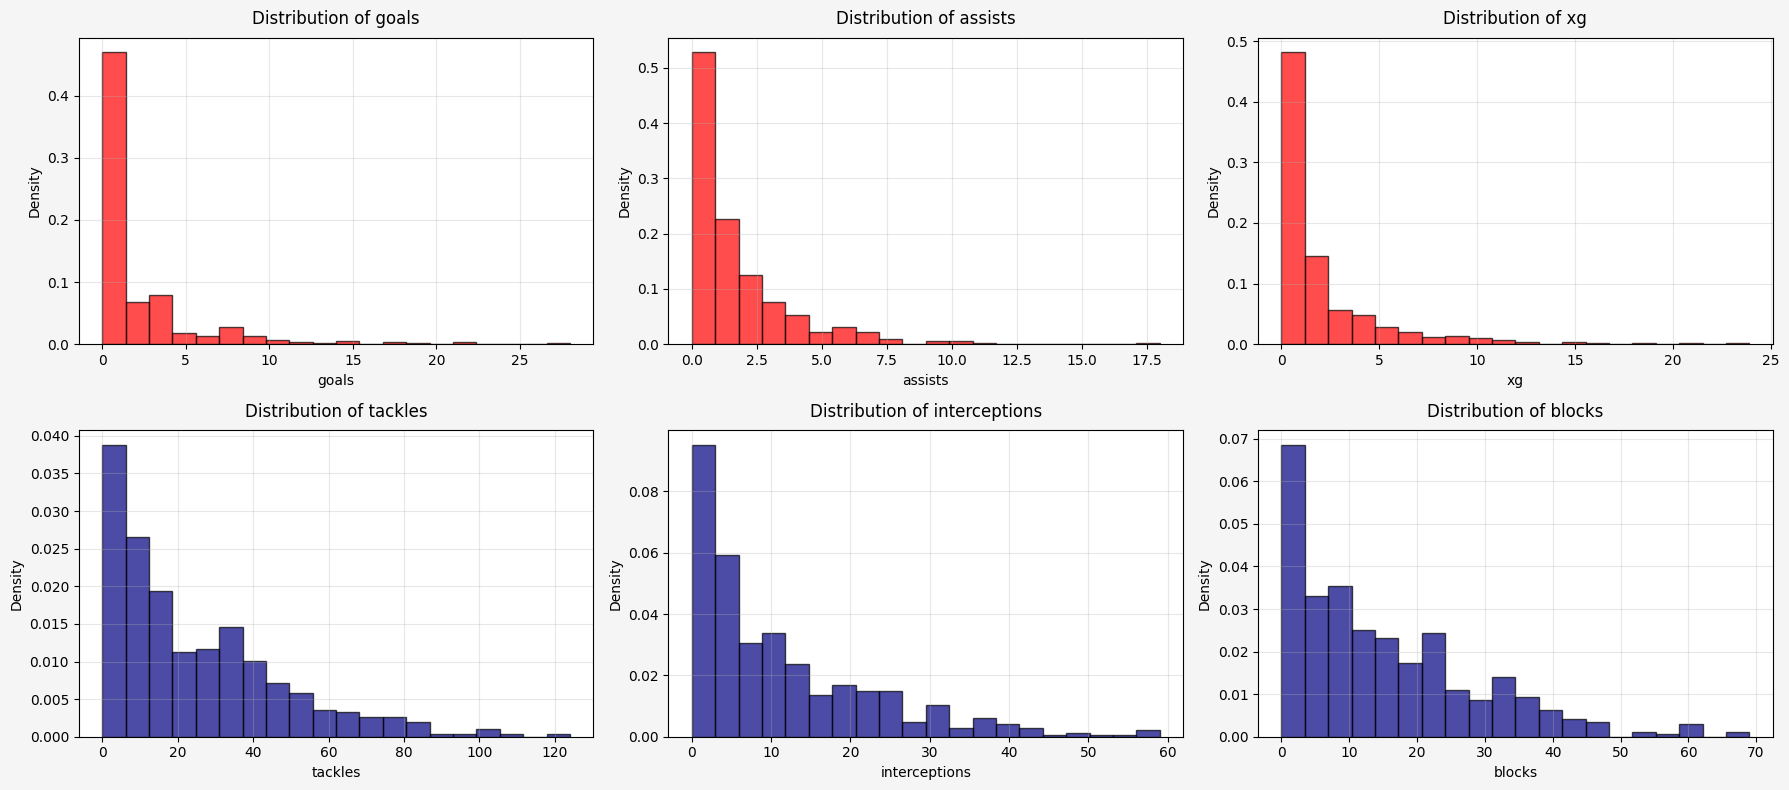

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_stat_histograms(df, output_file='stat_histograms.png'):
    attacking_stats = ['goals', 'assists', 'xg']
    defensive_stats = ['tackles', 'interceptions', 'blocks']

    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    fig.patch.set_facecolor('#f5f5f5')

    for i, stat in enumerate(attacking_stats):
        axes[0, i].hist(df[stat], bins=20, alpha=0.7, color='red', density=True, edgecolor='black')
        axes[0, i].set_title(f'Distribution of {stat}', fontsize=12, pad=10)
        axes[0, i].set_xlabel(stat, fontsize=10)
        axes[0, i].set_ylabel('Density', fontsize=10)
        axes[0, i].grid(True, alpha=0.3)
        axes[0, i].set_facecolor('#ffffff')

    for i, stat in enumerate(defensive_stats):
        axes[1, i].hist(df[stat], bins=20, alpha=0.7, color='navy', density=True, edgecolor='black')
        axes[1, i].set_title(f'Distribution of {stat}', fontsize=12, pad=10)
        axes[1, i].set_xlabel(stat, fontsize=10)
        axes[1, i].set_ylabel('Density', fontsize=10)
        axes[1, i].grid(True, alpha=0.3)
        axes[1, i].set_facecolor('#ffffff')

    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')  # Save as PNG
    plt.show()

df_copy_02 = df_copy_01.copy()
plot_stat_histograms(df_copy_02, output_file='stat_histograms.png')

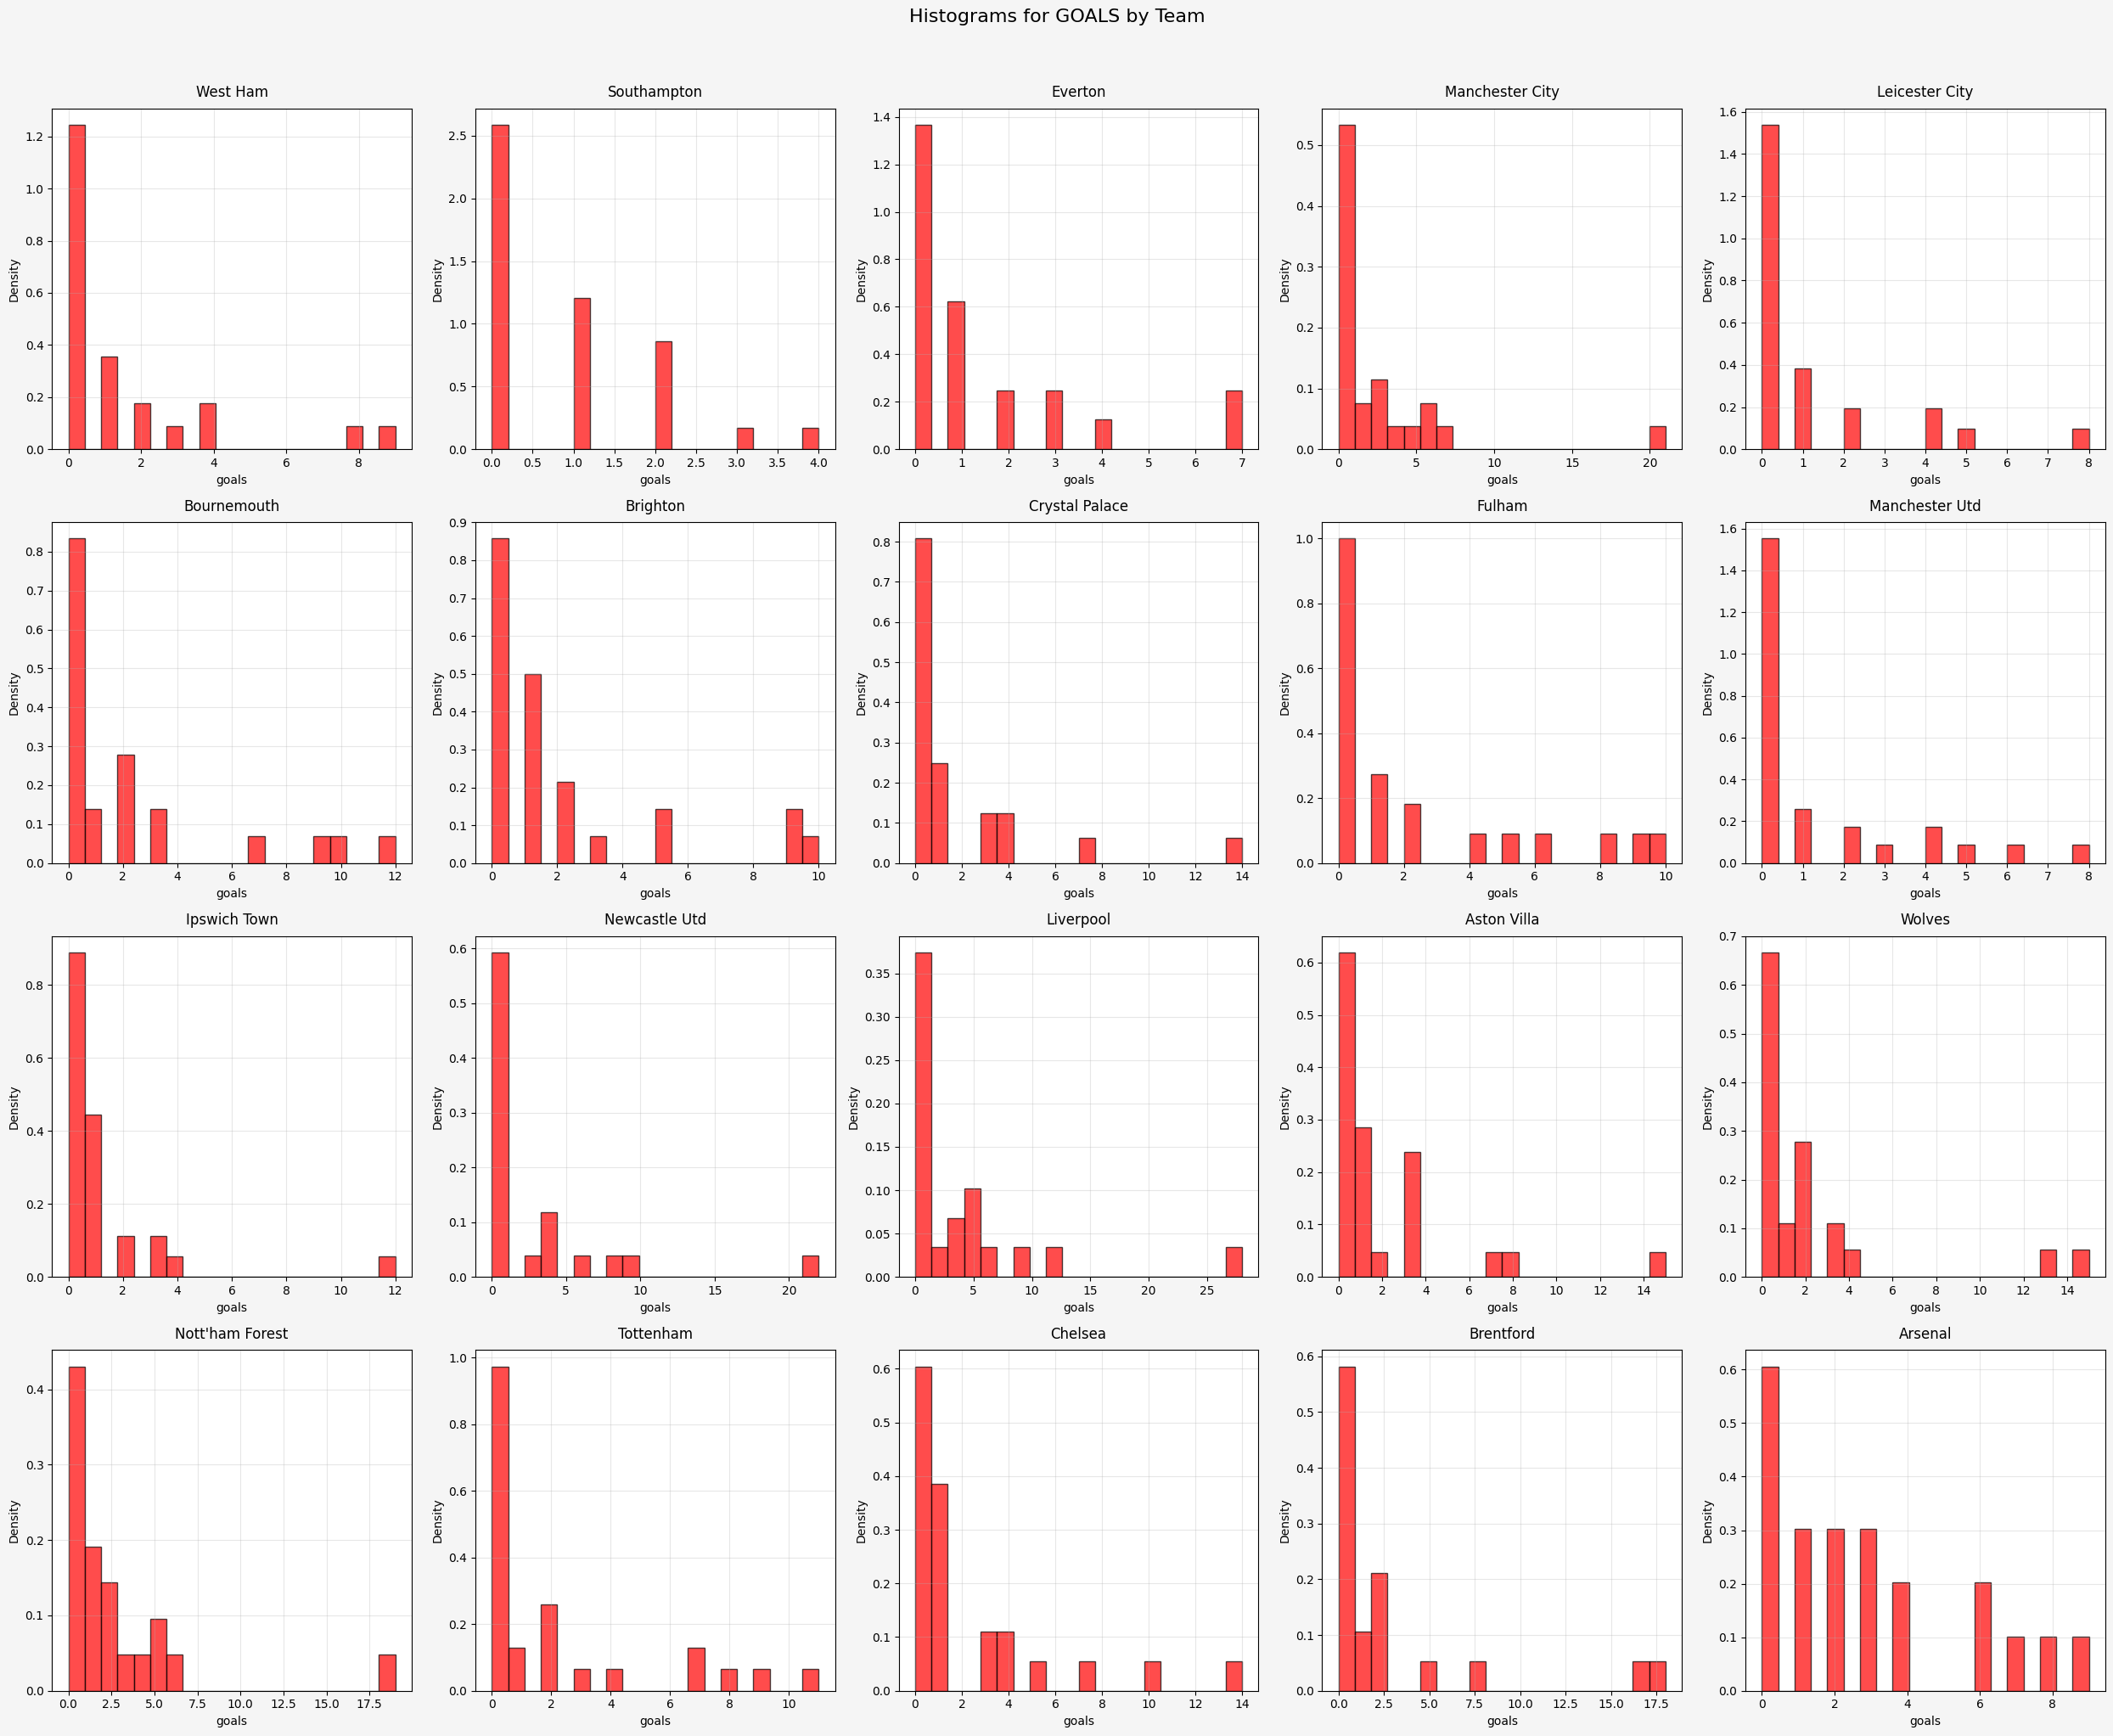

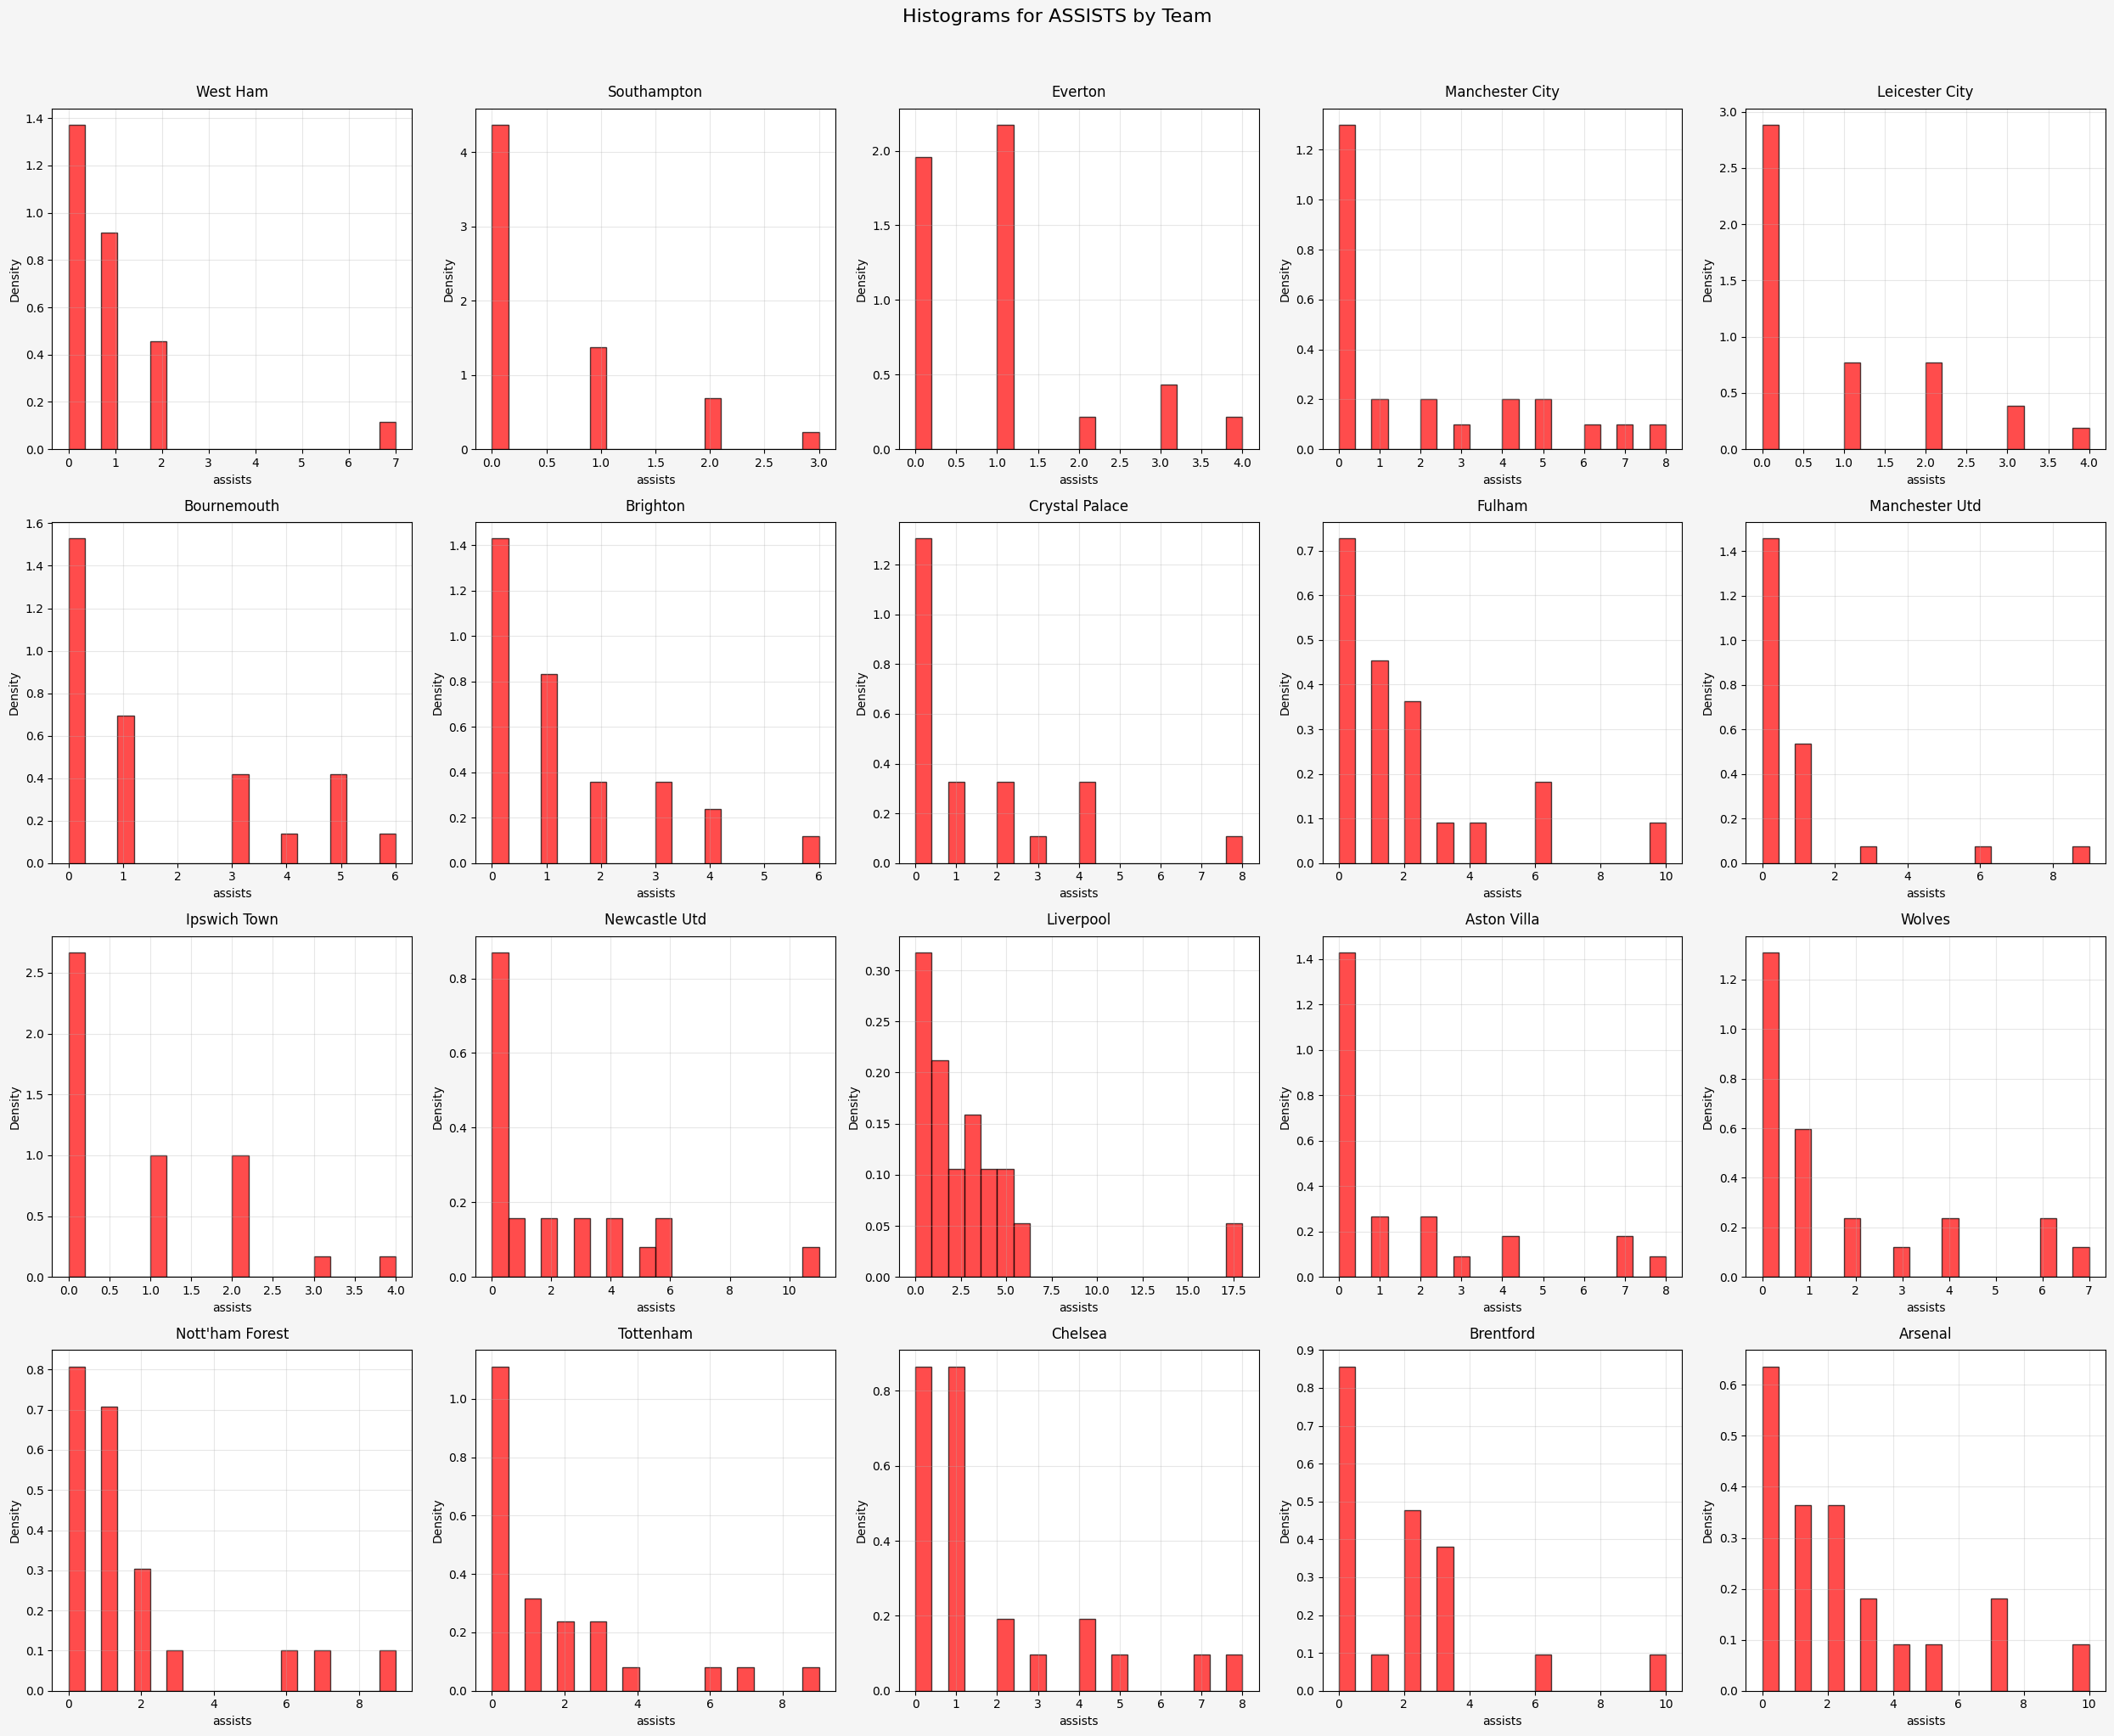

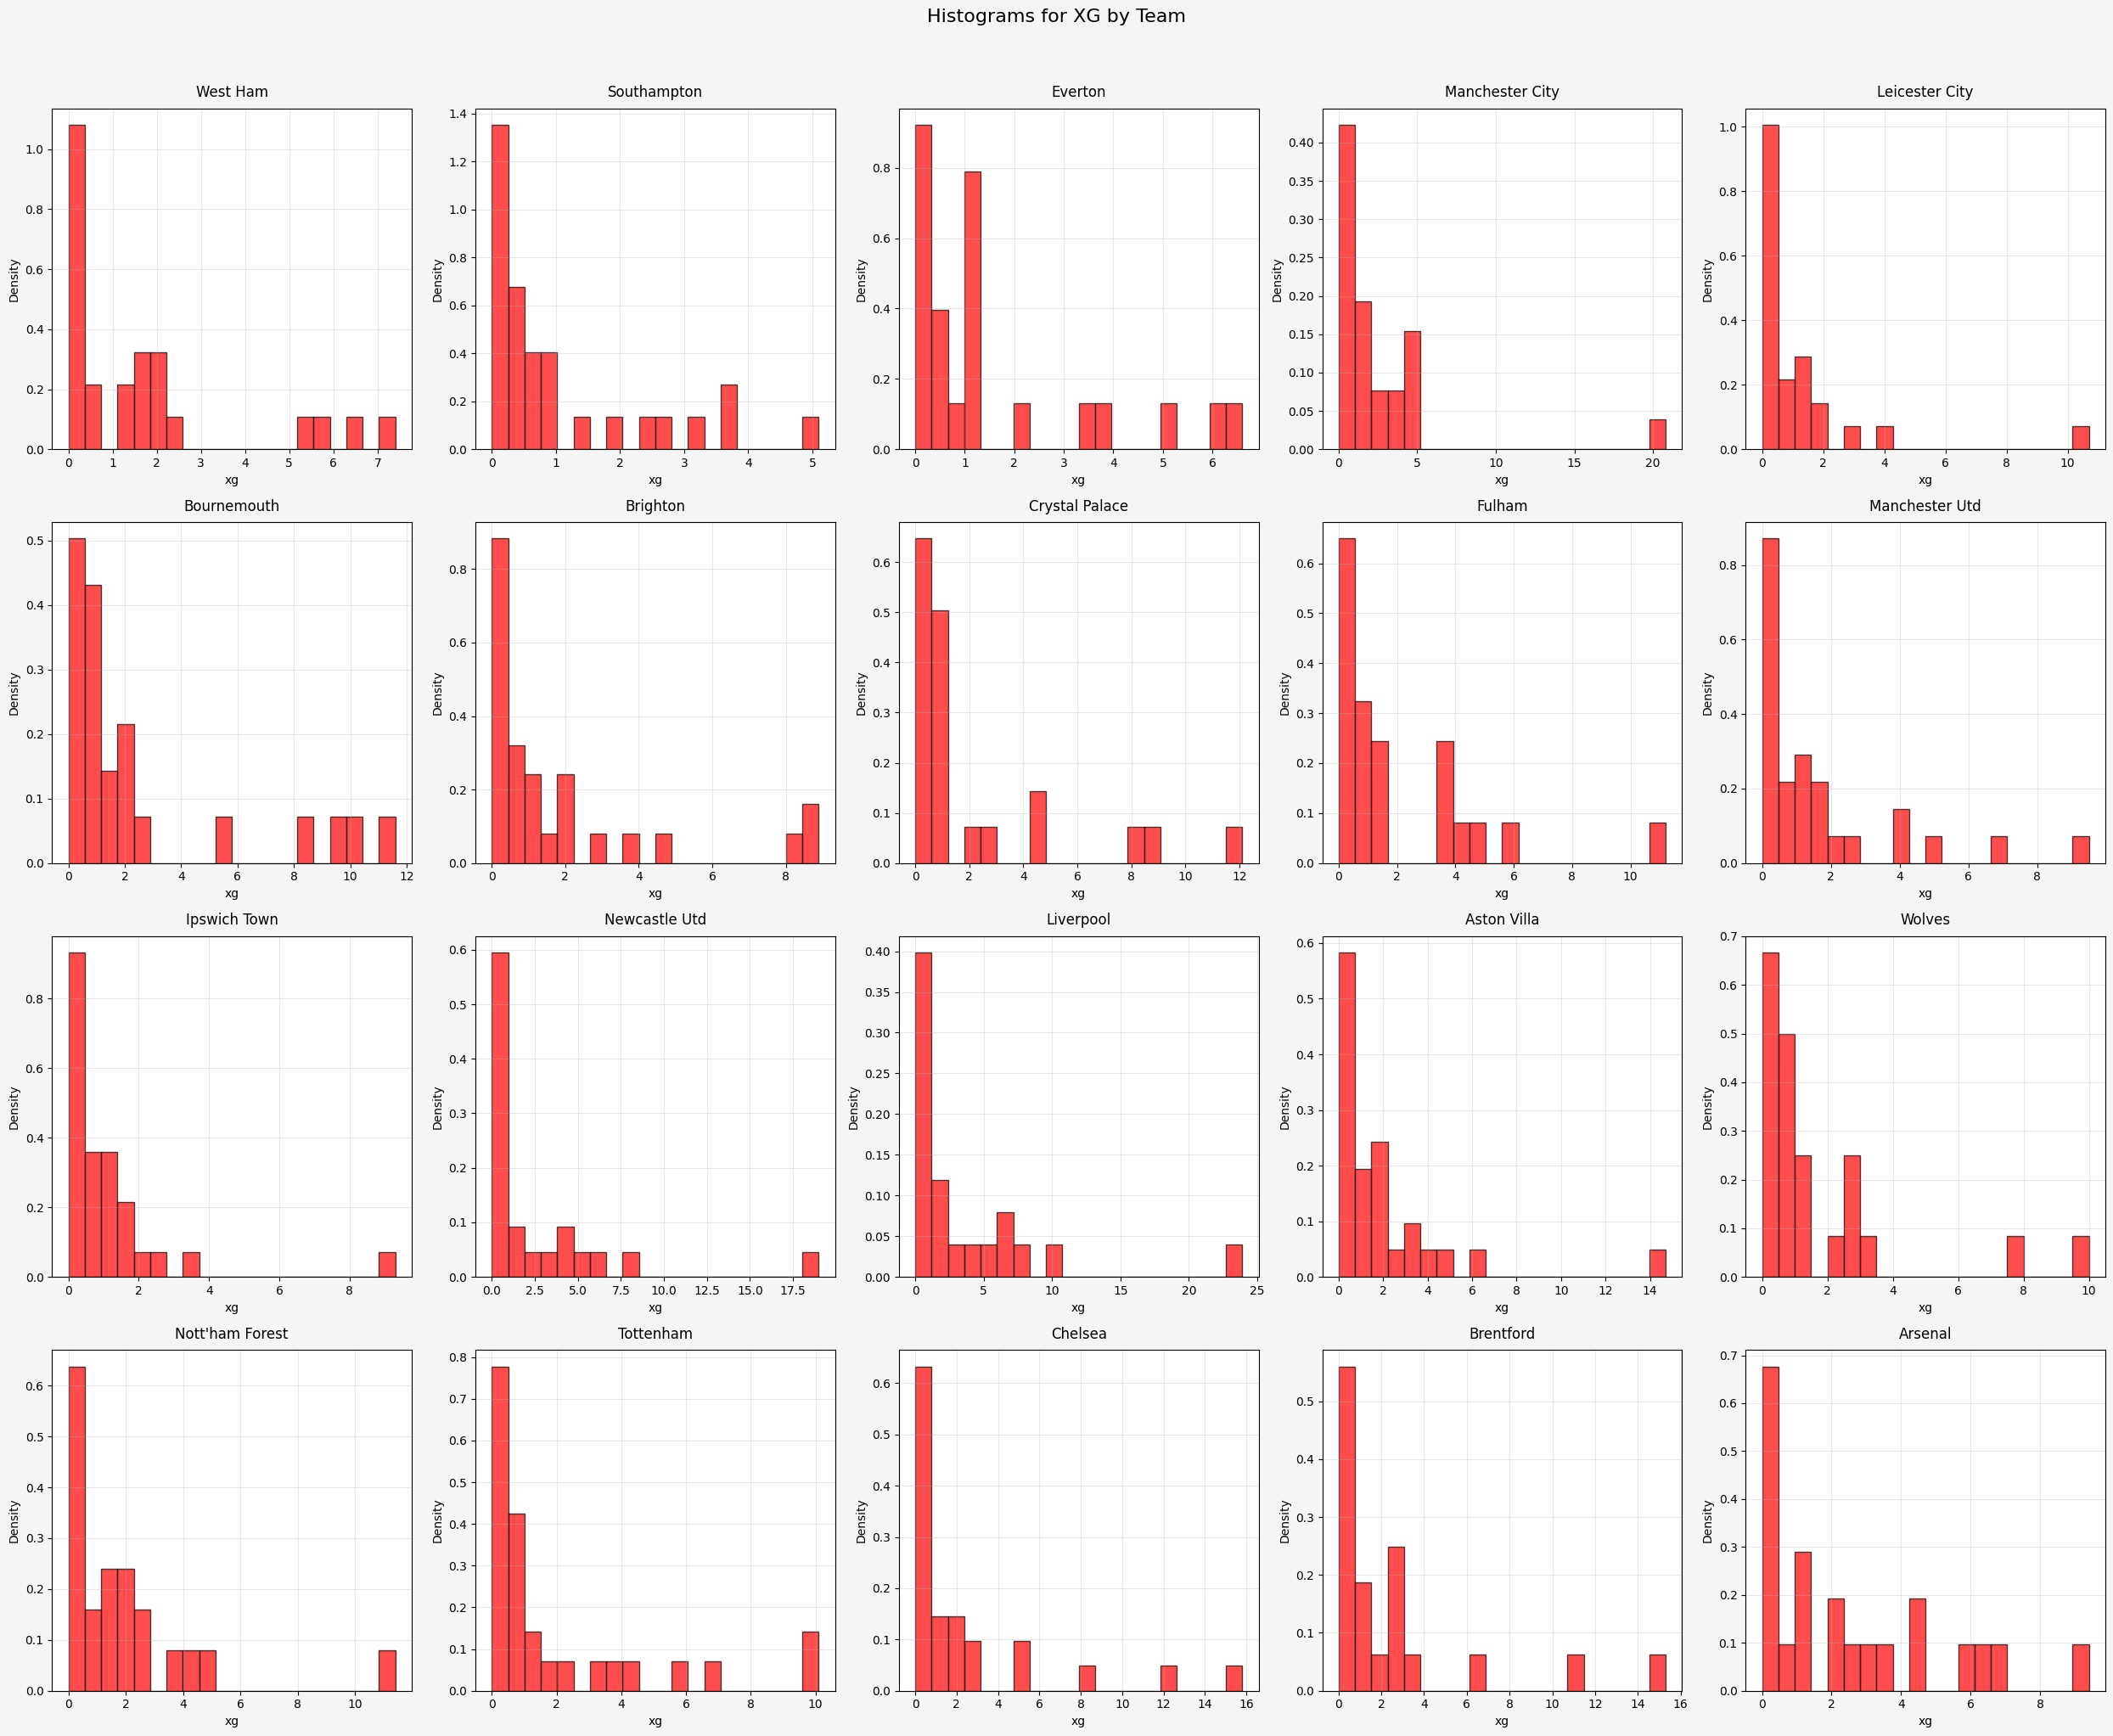

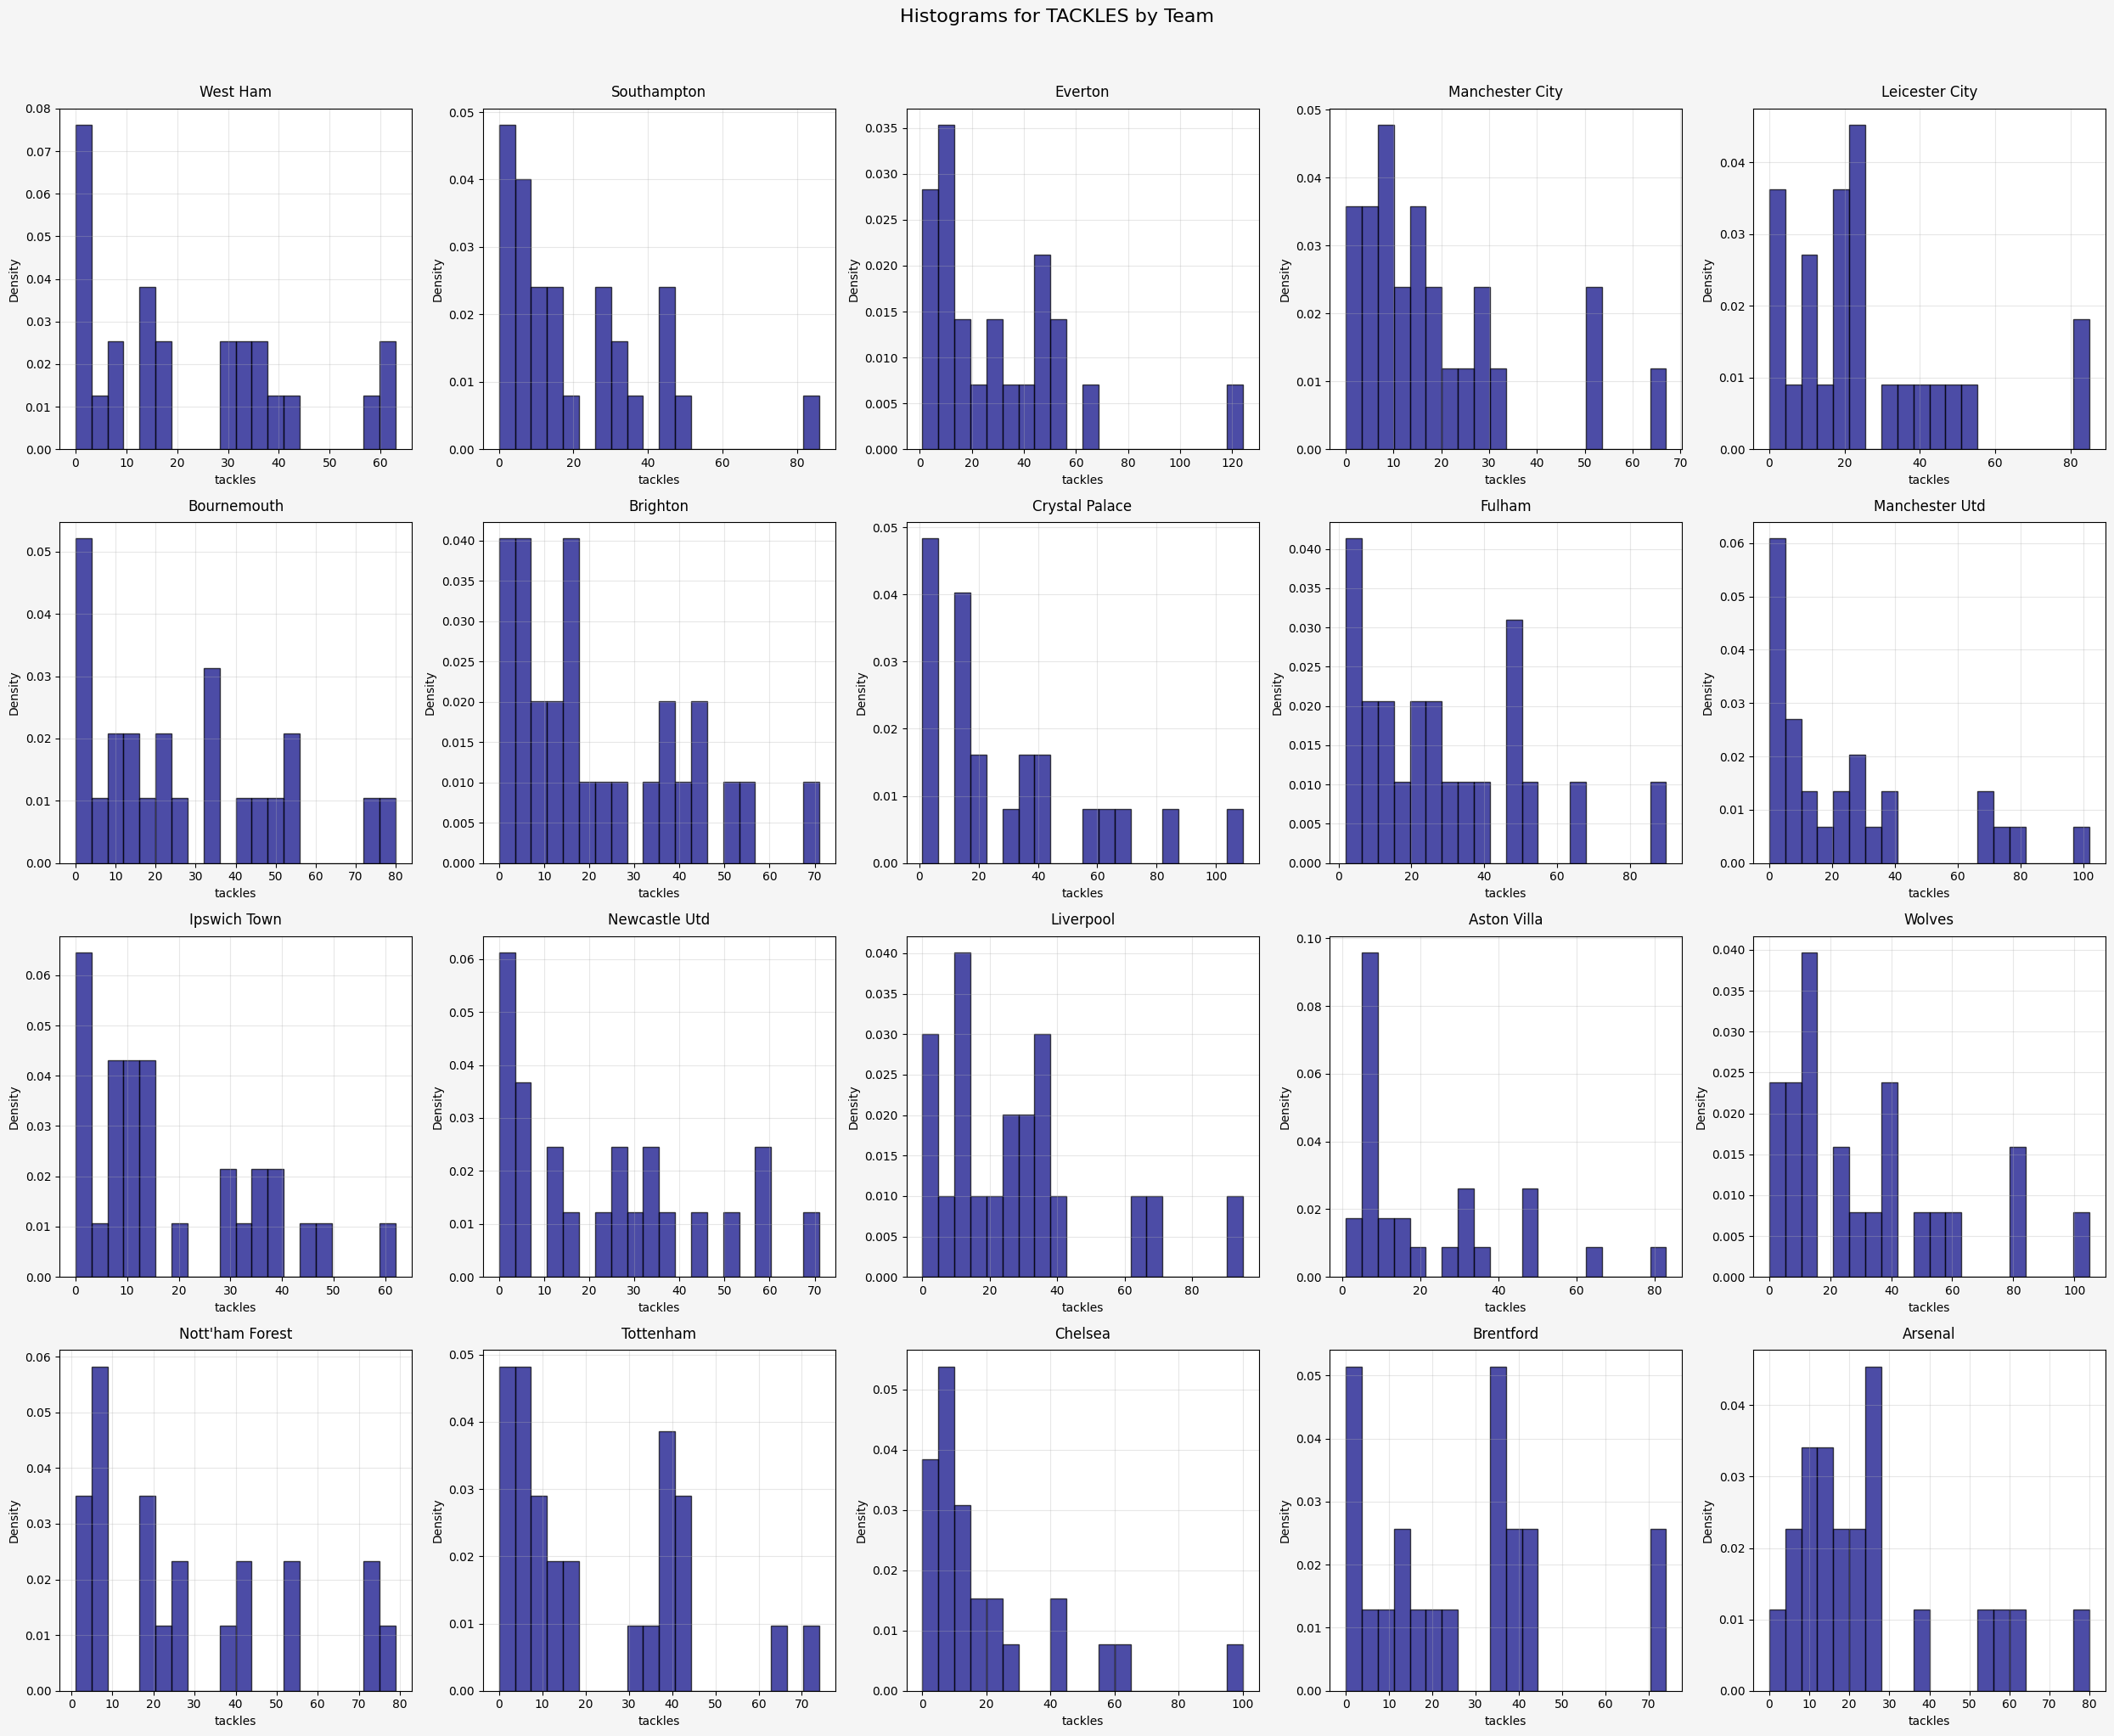

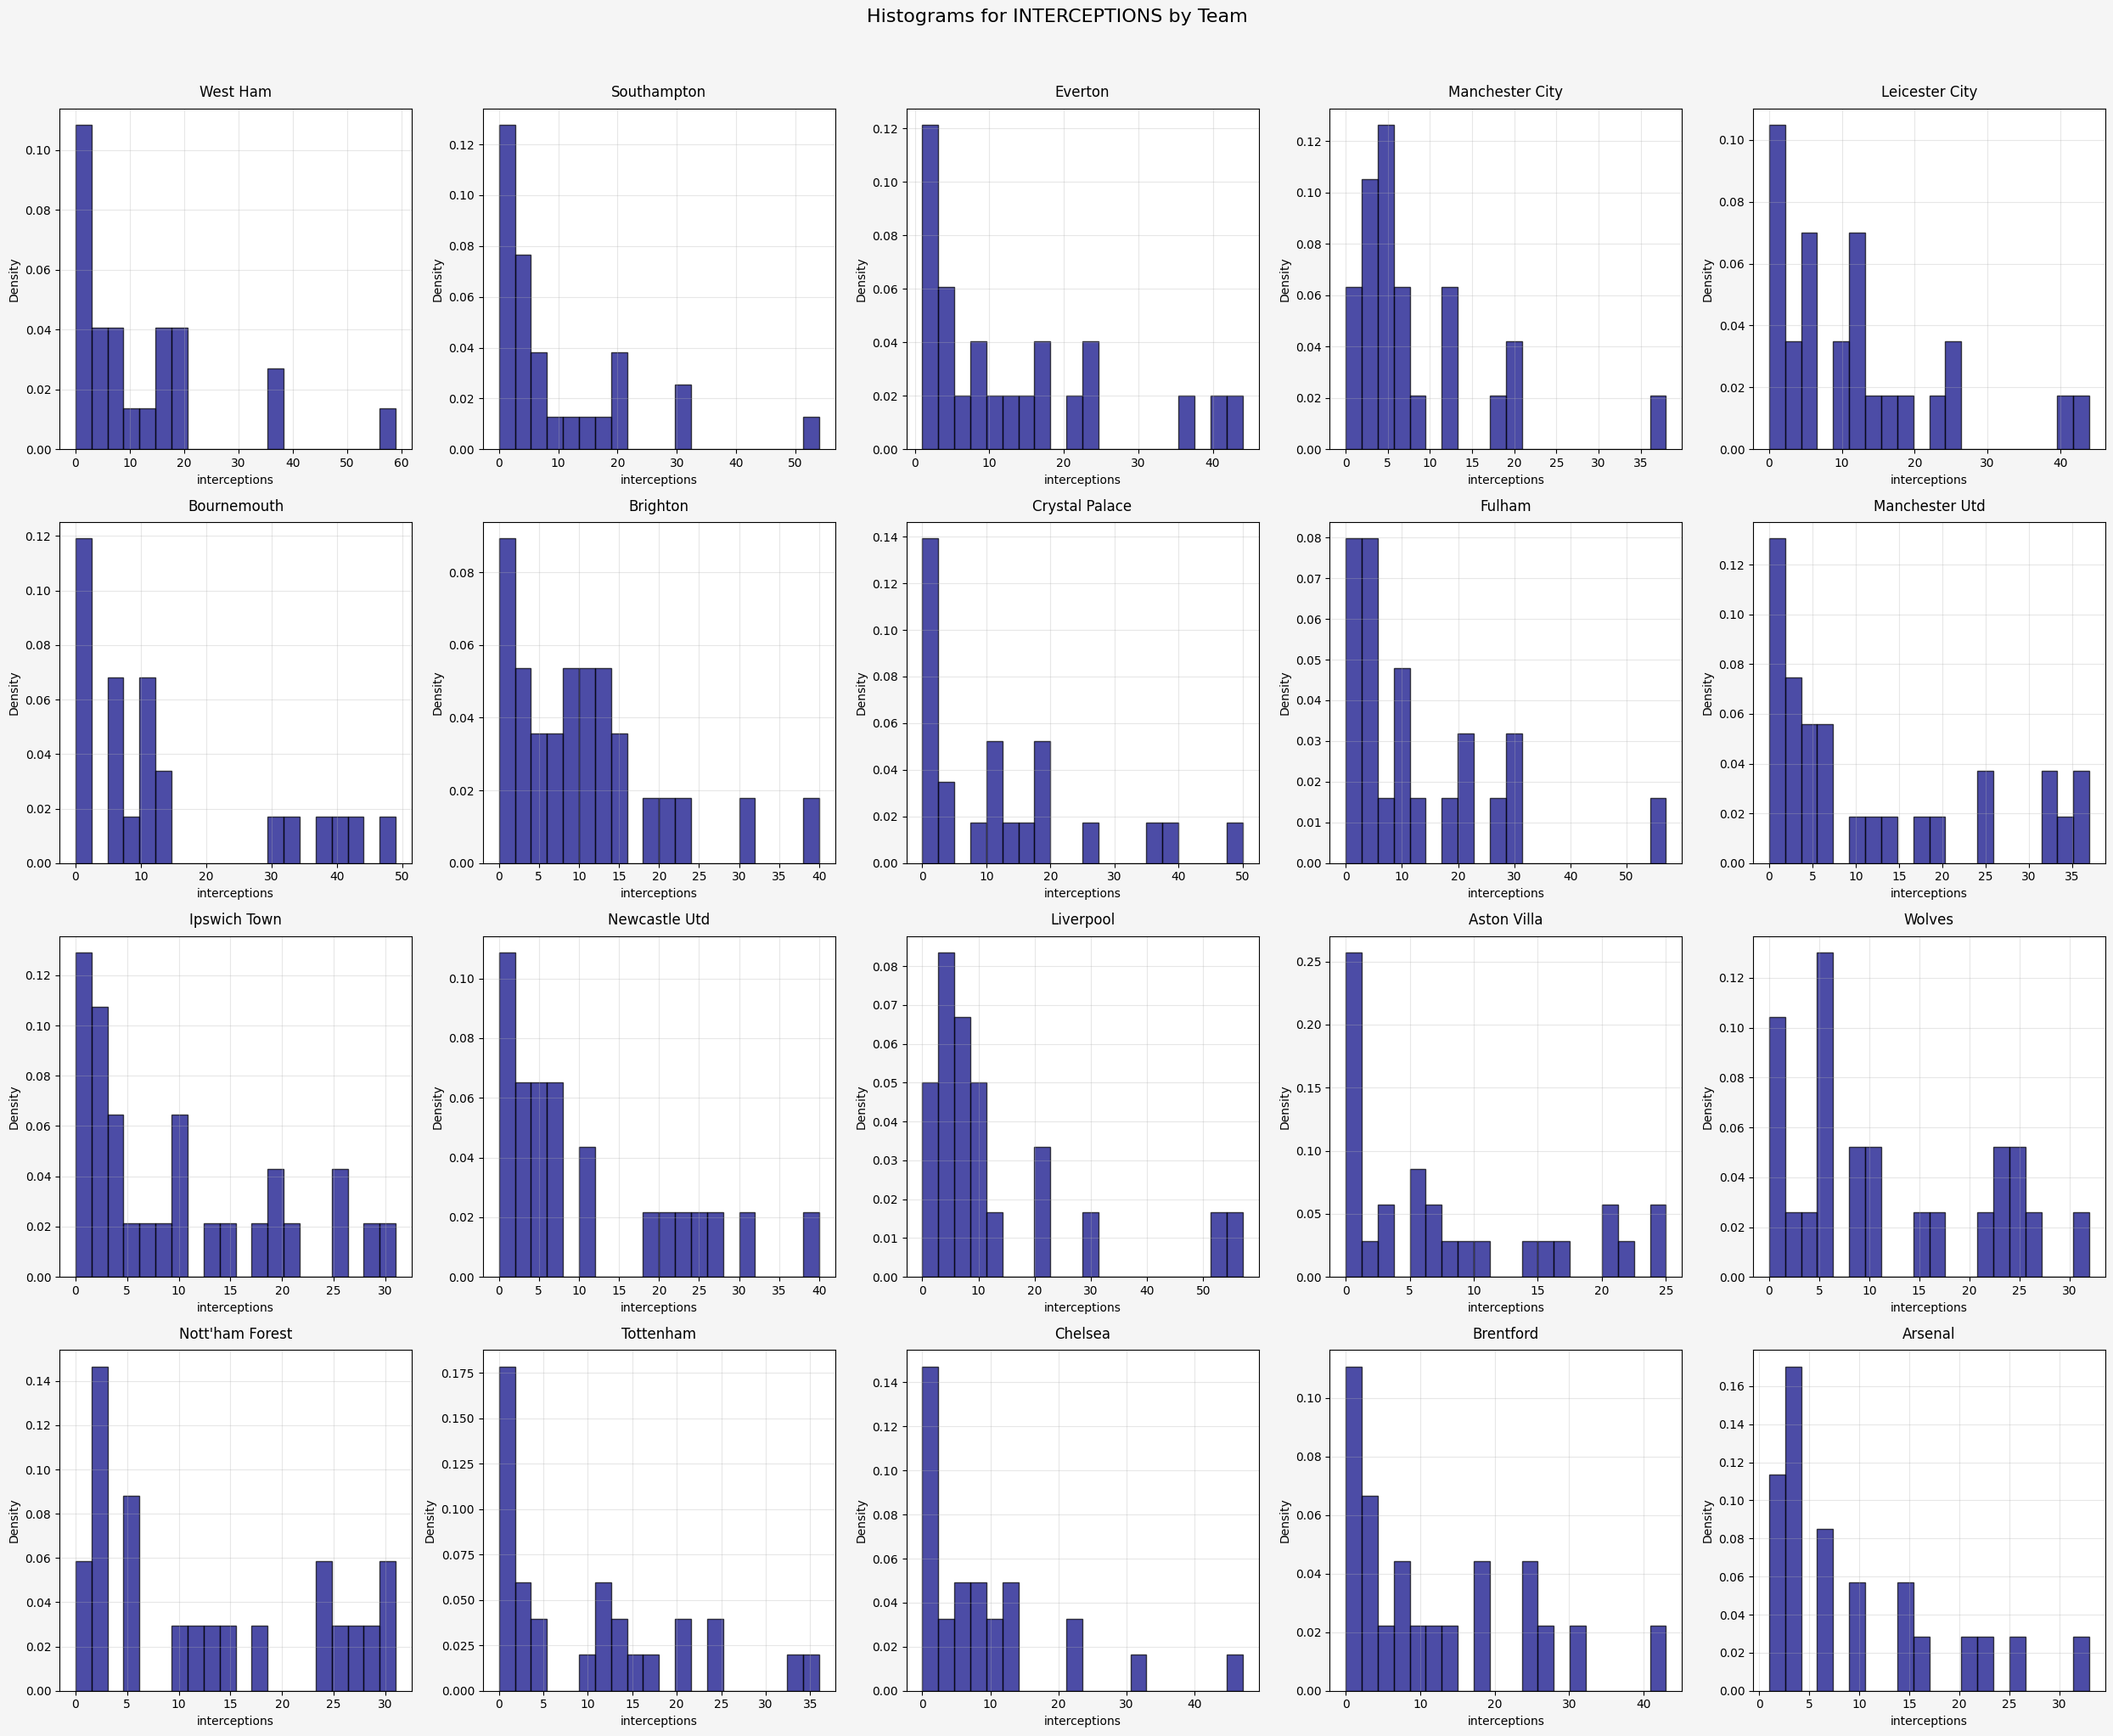

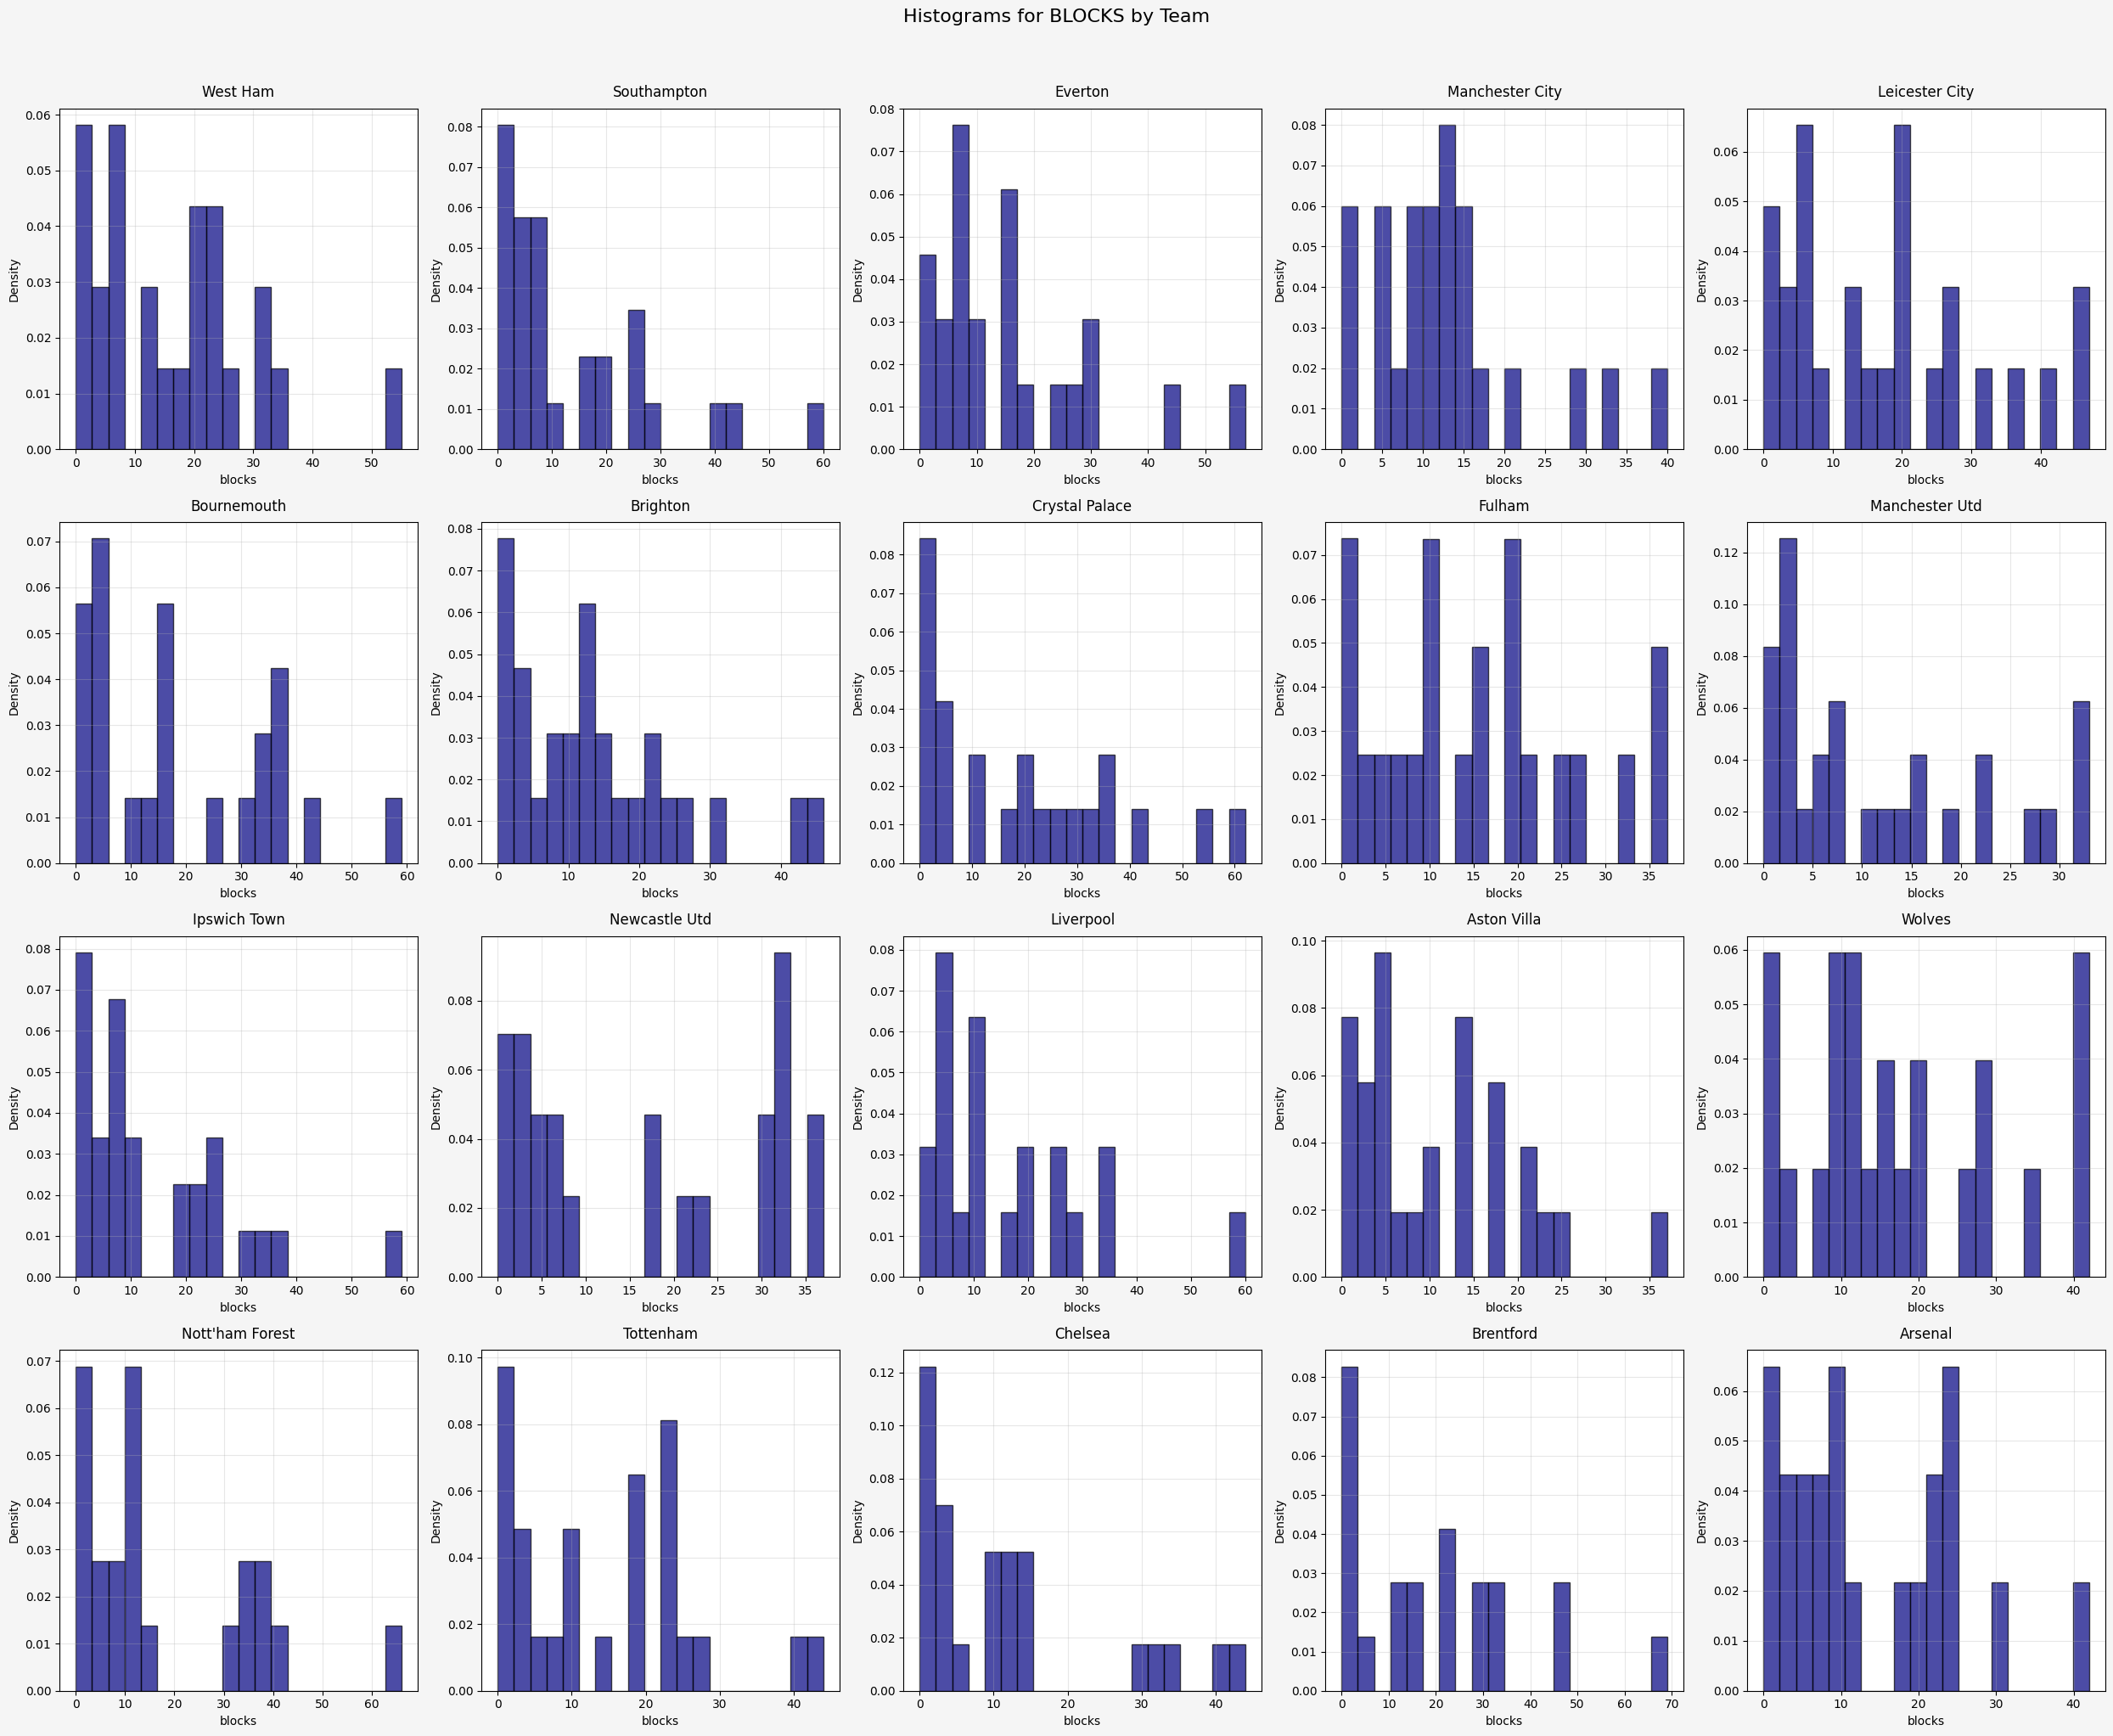

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_team_histograms(df):
    attacking_stats = ['goals', 'assists', 'xg']
    defensive_stats = ['tackles', 'interceptions', 'blocks']
    all_stats = attacking_stats + defensive_stats
    teams = df['team'].unique()

    for stat in all_stats:
        fig, axes = plt.subplots(4, 5, figsize=(25, 20))
        fig.patch.set_facecolor('#f5f5f5')
        fig.suptitle(f'Histograms for {stat.upper()} by Team', fontsize=16, y=1.02)
        axes = axes.flatten()

        color = 'red' if stat in attacking_stats else 'navy'

        for i, team in enumerate(teams):
            team_data = df[df['team'] == team][stat]
            axes[i].hist(team_data, bins=20, alpha=0.7, color=color, density=True, edgecolor='black')
            axes[i].set_title(f'{team}', fontsize=12, pad=10)
            axes[i].set_xlabel(stat, fontsize=10)
            axes[i].set_ylabel('Density', fontsize=10)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_facecolor('#ffffff')

        for i in range(len(teams), 20):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.show()

df_copy_03 = df_copy_01.copy()
plot_team_histograms(df_copy_03)

***EXCERCISE - 3:***

**1. Use the K-means algorithm to classify players into groups based on their statistics.**

**2. Use PCA to reduce the data dimensions to 2, then plot a 2D cluster of the data points.**

**3. Identify the team with the highest scores for each statistic. Based on your analysis, which team do you think is performing the best in the 2024-2025 Premier League season?**

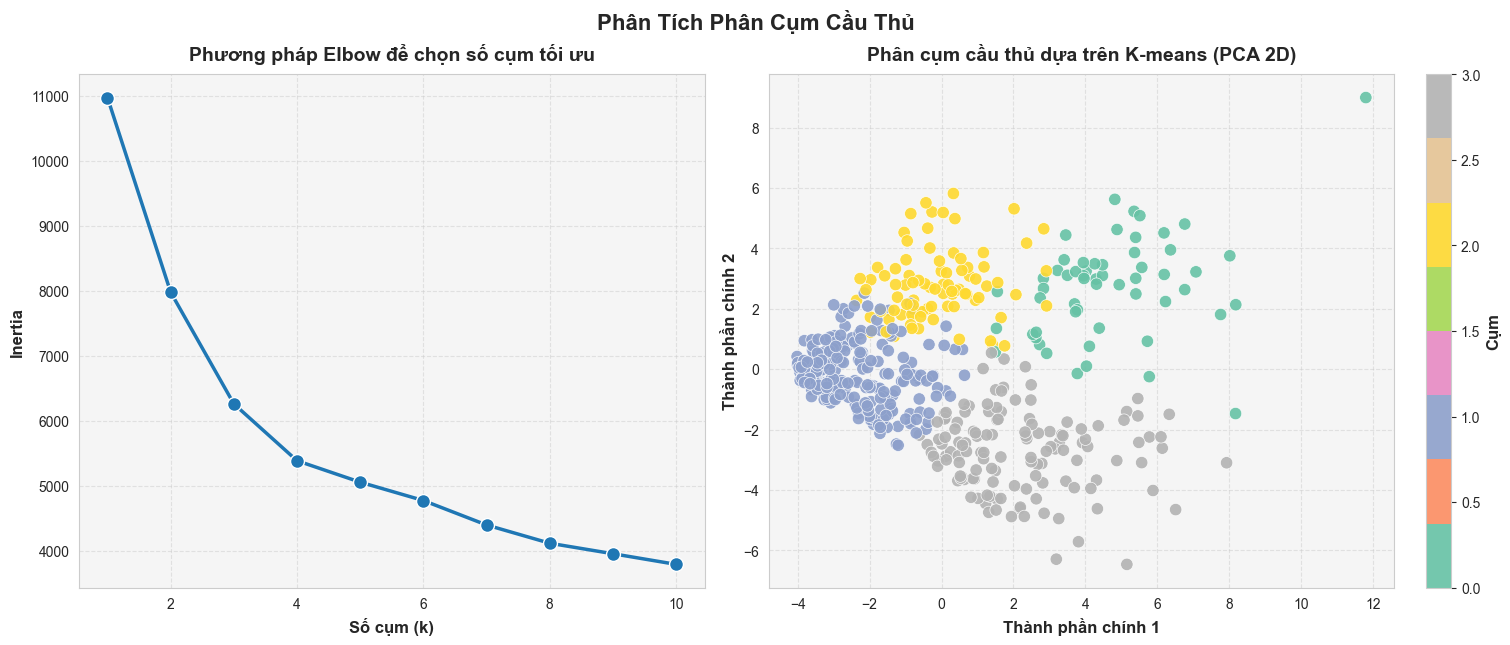

In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df_03 = df.copy()

features = [
    'goals_per90', 'assists_per90', 'xg_per90', 'xg_assist_per90',
    'progressive_carries_x', 'progressive_passes_x', 'progressive_passes_received_x',
    'shots_on_target_per90', 'goals_per_shot',
    'passes_completed', 'passes_pct', 'passes_into_final_third', 'passes_into_penalty_area',
    'tackles', 'tackles_won', 'interceptions', 'blocks',
    'touches_att_3rd', 'touches_att_pen_area', 'carries_into_penalty_area',
    'aerials_won', 'aerials_won_pct'
]

features = [f for f in features if f in df_03.columns]

for col in features:
    df_03[col] = pd.to_numeric(df_03[col], errors='coerce')
df_03[features] = df_03[features].fillna(0)

X = df_03[features].astype(float)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_03['Cluster'] = kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

sns.set_style("whitegrid")
plt.rcParams['axes.facecolor'] = '#f5f5f5'
plt.rcParams['figure.facecolor'] = '#ffffff'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

ax1.plot(K, inertia, 'o-', color='#1f77b4', markersize=10, linewidth=2.5, markeredgecolor='white')
ax1.set_xlabel('Số cụm (k)', fontsize=12, weight='bold')
ax1.set_ylabel('Inertia', fontsize=12, weight='bold')
ax1.set_title('Phương pháp Elbow để chọn số cụm tối ưu', fontsize=14, weight='bold', pad=10)
ax1.grid(True, linestyle='--', alpha=0.5)

scatter = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=df_03['Cluster'], cmap='Set2', s=80, alpha=0.9, edgecolors='white', linewidth=0.5)
cbar = fig.colorbar(scatter, ax=ax2)
cbar.set_label('Cụm', fontsize=12, weight='bold')
ax2.set_xlabel('Thành phần chính 1', fontsize=12, weight='bold')
ax2.set_ylabel('Thành phần chính 2', fontsize=12, weight='bold')
ax2.set_title('Phân cụm cầu thủ dựa trên K-means (PCA 2D)', fontsize=14, weight='bold', pad=10)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.suptitle('Phân Tích Phân Cụm Cầu Thủ', fontsize=16, weight='bold', y=1.05)
plt.savefig('player_clustering.png', dpi=300, bbox_inches='tight')
plt.show()

result = df_03[['player', 'team', 'position', 'Cluster'] + features]

for cluster in range(optimal_k):
    cluster_data = result[result['Cluster'] == cluster]

result.to_csv('clustered_players.csv', index=False)

***EXERCISE - 4:***

**1. Collect player transfer values for the 2024-2025 season from 
https://www.footballtransfers.com. Note that only collect for the players whose playing 
time is greater than 900 minutes**

**2. Propose a method for estimating player values. How do you select feature and model?**



In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
import time

def setup_driver():
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--disable-gpu')
    chrome_options.add_argument('--no-sandbox')
    driver = webdriver.Chrome(options=chrome_options)
    return driver

def scrape_page(driver, url):
    driver.get(url)
    time.sleep(3)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table', class_='table table-hover no-cursor table-striped leaguetable mvp-table similar-players-table mb-0')
    if not table:
        return []
    
    data = []
    rows = table.find('tbody').find_all('tr')
    
    for row in rows:
        try:
            skill_div = row.find('div', class_='table-skill__skill')
            pot_div = row.find('div', class_='table-skill__pot')
            skill = float(skill_div.text.strip()) if skill_div else None
            pot = float(pot_div.text.strip()) if pot_div else None
            skill_pot = f"{skill}/{pot}" if skill and pot else None
            
            player_span = row.find('span', class_='d-none')
            player_name = player_span.text.strip() if player_span else None
            
            team_span = row.find('span', class_='td-team__teamname')
            team = team_span.text.strip() if team_span else None
            
            etv_span = row.find('span', class_='player-tag')
            etv = etv_span.text.strip() if etv_span else None
            
            data.append({
                'player_name': player_name,
                'team': team,
                'price': etv,
                'skill/pot': skill_pot
            })
        except:
            continue
    
    return data

base_url = "https://www.footballtransfers.com/en/players/uk-premier-league"
total_pages = 22
all_data = []

driver = setup_driver()

try:
    for page in range(1, total_pages + 1):
        if page == 1:
            url = base_url
        else:
            url = f"{base_url}/{page}"
        page_data = scrape_page(driver, url)
        all_data.extend(page_data)
finally:
    driver.quit()

df_final = pd.DataFrame(all_data)
df_final.to_csv('football_transfers_players.csv', index=False)

In [125]:
import pandas as pd
df_copy = df.copy()
df_final_copy = df_final.copy()
df_final_copy = df_final[['player_name', 'price', 'skill/pot']]
df_copy['minutes'] = df_copy['minutes'].str.replace(',', '').astype(float)
df_copy = df_copy[df_copy['minutes'] > 900]

df_merge = pd.merge(df_copy, df_final_copy, left_on = 'player', right_on = 'player_name', how = 'inner')

df_merge = df_merge.drop(columns = 'player_name')
df_merge = df_merge.drop(columns = 'No.')

df_merge.to_csv('df_merge.csv', index = True)

In [132]:
features = [
    'player', 'nationality', 'team', 'position', 'birth_year', 'games', 'games_starts', 'minutes',
    'goals', 'assists', 'cards_yellow', 'cards_red', 'xg', 'xg_assist', 'goals_per90', 'assists_per90',
    'xg_per90', 'xg_assist_per90', 'shots_on_target_pct', 'shots_on_target_per90', 'goals_per_shot',
    'average_shot_distance', 'passes_completed', 'passes_pct', 'passes_total_distance', 'passes_pct_short',
    'passes_pct_medium', 'passes_pct_long', 'assisted_shots', 'passes_into_final_third',
    'passes_into_penalty_area', 'crosses_into_penalty_area', 'sca', 'sca_per90', 'gca', 'gca_per90',
    'tackles', 'tackles_won', 'challenges', 'challenges_lost', 'blocks', 'blocked_shots',
    'blocked_passes', 'interceptions', 'touches', 'touches_def_pen_area', 'touches_def_3rd',
    'touches_mid_3rd', 'touches_att_3rd', 'touches_att_pen_area', 'take_ons', 'take_ons_won',
    'take_ons_tackled', 'carries', 'carries_progressive_distance', 'progressive_carries_x',
    'carries_into_final_third', 'carries_into_penalty_area', 'miscontrols', 'dispossessed',
    'passes_received', 'progressive_passes_received_x'
]


Mean Squared Error: 173262539930166.28
R^2 Score: 0.4148


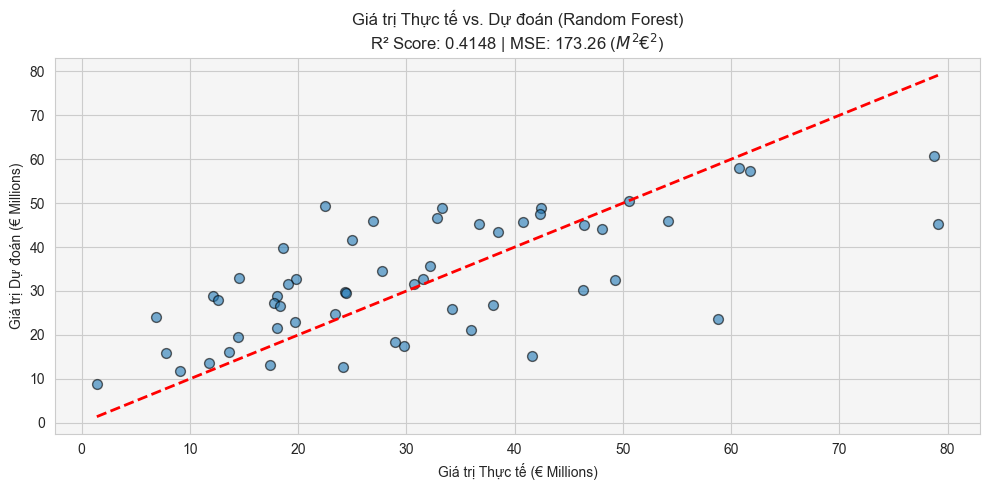

In [158]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns 



def convert_price(price):
    if isinstance(price, str):
        price = price.replace('€', '').strip()
        if 'M' in price:
            return float(price.replace('M', '')) * 1e6
        elif 'K' in price:
             return float(price.replace('K', '')) * 1e3
        try:
            return float(price)
        except ValueError:
            return np.nan
    elif isinstance(price, (int, float)):
        return price
    return np.nan

df_merge['price'] = df_merge['price'].apply(convert_price)
df_merge.dropna(subset=['price'], inplace=True) 


categorical_cols = df_merge.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_merge.select_dtypes(include=np.number).columns.tolist()

cols_to_drop = ['player', 'nationality', 'team', 'position', 'price', 'skill/pot', 'player_name', 'No.']
features_potential = [col for col in numerical_cols if col not in cols_to_drop and col in df_merge.columns]

encoders = {}
for col in ['nationality', 'team', 'position']:
     if col in df_merge.columns:
        le = LabelEncoder()
        df_merge[col] = df_merge[col].astype(str)
        df_merge[col] = le.fit_transform(df_merge[col])
        encoders[col] = le 
        if col not in features_potential: 
             features_potential.append(col)

final_features = []
for col in features_potential:
    if col in df_merge.columns and pd.api.types.is_numeric_dtype(df_merge[col]):
        final_features.append(col)
    elif col in encoders.keys():
         final_features.append(col)


X = df_merge[final_features]
y = df_merge['price']

X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15, min_samples_split=5, min_samples_leaf=3) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.4f}")

importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': final_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
plt.scatter(y_test / 1e6, y_pred / 1e6, alpha=0.6, edgecolors='k', s=50) 
plt.plot([min(y_test / 1e6), max(y_test / 1e6)], [min(y_test / 1e6), max(y_test / 1e6)], '--', color='red', lw=2) 
plt.title(f'Giá trị Thực tế vs. Dự đoán (Random Forest)\nR² Score: {r2:.4f} | MSE: {mse / 1e12:.2f} ($M^2€^2$)') 
plt.xlabel('Giá trị Thực tế (€ Millions)')
plt.ylabel('Giá trị Dự đoán (€ Millions)')
plt.grid(True)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, format='png', bbox_inches='tight')
plt.show() 
